## DSCI 100 Group Project 

By Tony Fu, Hao Jiang, and Aimee Garcia Castro

## Introduction: 

Many elements play a role in how well a student will perform on a test. The objective of this group project is to predict the knowledge level of an individual based on such elements. We will be looking at the "User Knowledge" dataset obtained from the UCI Machine Learning Repository. The data in this dataset looks at `STG` (study time for main topics), `SCG` (repetition in studying), `STR` (study time for related topics), `LPR` (exam performance of related topics), and `PEG` (exam performance of main topics). It also relates `PEG` to `UNS` (knowledge level). All variables from `STG` to `PEG` have a range from 0 to 1. `UNS` contains the labels `very_low`, `low`, `middle`, and `high`, where `very_low` corresponds to a much lower knowledge level whereas `high` corresponds to a higher knowledge level.
 
The predictive question that we will try to answer is: "Can we predict if an individual's `UNS` will be `very low`, `low`, `middle`, or `high` based on factors such as `STG`, `SCG`, and `STR`?"

## Loading and Tidying the Data: 

We begin by loading the libraries required to perform exploratory analysis. We have also used the `set.seed` function to make sure our findings for the classification are reproducible. 

In [2]:
library(tidyverse)
library(ggplot2)
library(tidymodels)
library(repr)
library(GGally)
library(readxl)
options(repr.matrix.max.rows = 6)
set.seed(2021)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

We need to transfer the data from the website to R since the data is located on the website. As the data is available as an Excel spreadsheet, we will need to download it as a file with `download.file`. We have stored the file described as an url from the Internet as an object called `url`.

After we have downloaded the data as a file on R, we will use the `read_excel` function to transfer the data from the spreadsheet. We will use `sheet = 2` as the second sheet is listed as **training data** in the spreadsheet, which would be crucial once we create our classifier.

We notice that the last three columns are irrelevant to the data so we will be selecting the wanted data with the `select` function.

Furthermore, although not required, we chose to lowercase all the `UNS` labels to keep the labelling consistent with the `mutate` and `recode` functions.

In [77]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"

download.file(url, destfile = "Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls")

user_knowledge <- read_excel(path = "Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls", sheet = 2) %>%
    select(STG:UNS) %>%
    mutate(UNS = recode(UNS, High = 'high', Middle = 'middle', Low = 'low'))

user_knowledge

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,high
0.06,0.06,0.05,0.25,0.33,low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,high
0.50,0.75,0.81,0.61,0.26,middle
0.66,0.90,0.76,0.87,0.74,high


*Table 1*: Tidied "User Knowledge" data set obtained from UCI Machine Learning Repository

We can see the data is tidy as each variable is its own column, each observation is in its own row, and each cell has one value.

## Searching for NAs:

We will now be looking for NA values in our data set, and handle them appropriately as they represent a missing value in our data. 

In [78]:
sum(is.na(user_knowledge))

[1] 0

Thankfully there are no NAs in our data frame, so no further adjustments must be made to our data set.

## Choosing Potential Predictors

To begin, we have decided to remove `LPR` since we expect a high `LPR` would result from a high `STR`. If we include both as predictors, we would essentially be using the same predictor `STR` twice. This leads to `STR` having a larger influence than wanted. We have also decided to remove `PEG` since `UNS` is based on `PEG`, meaning `PEG` will have a larger influence than other possible predictors. We want to avoid predictors that would render other predictors less meaningful as it would defeat the purpose of making predictions with a set of predictors. 

In [3]:
user_knowledge <- user_knowledge %>%
    select(-LPR, -PEG)

user_knowledge

STG,SCG,STR,UNS
<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,very_low
0.08,0.08,0.10,high
0.06,0.06,0.05,low
⋮,⋮,⋮,⋮
0.54,0.82,0.71,high
0.50,0.75,0.81,middle
0.66,0.90,0.76,high


*Table 2*: Potential predictors that may be used for analysis

Now, four variables remain: `STG`, `SCG`, `STR`, and `UNS`. Since the categorical class we are predicting is `UNS`, we must turn it into a factor. This is done by using the `mutate` and `as_factor` functions.

In [79]:
user_knowledge <- user_knowledge %>%
    mutate(UNS = as.factor(UNS))

user_knowledge

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,high
0.06,0.06,0.05,0.25,0.33,low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,high
0.50,0.75,0.81,0.61,0.26,middle
0.66,0.90,0.76,0.87,0.74,high


*Table 2*: Potential predictors with `UNS` changed to class "factor"

We need to see which predictors we should use and which ones should be removed. We will do this through a method called forward selection, where we build a model by adding one predictor at a time. This model will select the most accurate combinations given the potential predictors `STG`, `SCG`, and `STR`, `LPR`, and, `PEG`. 

*Note: The following code was taken from Chapter 6.8 of the textbook.*

In [35]:
names <- colnames(user_knowledge %>% select(-UNS)) 
example_formula <- paste("UNS", "~", paste(names, collapse="+"))

accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

user_knowledge_vfold <- vfold_cv(user_knowledge, v = 5, strata = UNS)

n_total <- length(names)

selected <- c()

for (i in 1:n_total) {
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        preds_new <- c(selected, names[[j]])
        model_string <- paste("UNS", "~", paste(preds_new, collapse="+"))

        user_knowledge_recipe <- recipe(as.formula(model_string), 
                                data = user_knowledge) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())
        
        acc <- workflow() %>%
          add_recipe(user_knowledge_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = user_knowledge_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>%
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,UNS ~ PEG,0.8485839
2,UNS ~ PEG+LPR,0.9533769
3,UNS ~ PEG+LPR+SCG,0.9376906
4,UNS ~ PEG+LPR+SCG+STG,0.8952070
5,UNS ~ PEG+LPR+SCG+STG+STR,0.8058824


*Table 3*: Accuracies of different number of predictors used in the model

As seen in the table, the most accurate predictor is `PEG`. The second most would be `LPR`, since the model seleceted `PEG` and `LPR` as the most accurate combination when using two predictors. We thought this would be the case as knowledge level would be directly connected to exam performance, indicating a higher exam performance would lead to a higher knowledge level. After that, we noticed a gradual decrease in accuracy when we added `SCG`, `STG`, and `STR`. This drop in accuracy signifies that `SCG`, `STG`, and `STR` are more irrelevant predictors compared to `PEG` and `LPR`. Hence, we will not be using them as predictors. To validate our decision, we tried removing `PEG` from the data set to have the model measure the accuracy of the combination of `LPR` with these predictors. Likewise, we removed `LPR` to measure the accuracy of the combination of `PEG` and `SCG`. We found that the original combination of `PEG` and `LPR` resulted in the highest accuracy while looking at two predictors, which means that we will use them in our analysis as we require at least two predictors to create a visualization. Thus, we can remove `SCG`, `STG`, and `STR` from our data frame.

In [80]:
user_knowledge <- user_knowledge %>%
    select(-SCG, -STG, -STR)

user_knowledge

LPR,PEG,UNS
<dbl>,<dbl>,<fct>
0.00,0.00,very_low
0.24,0.90,high
0.25,0.33,low
⋮,⋮,⋮
0.29,0.77,high
0.61,0.26,middle
0.87,0.74,high


*Table 4*: Predictors that will be used for analysis

Therefore, the predictors we will use are `PEG` and `LPR` with `UNS` being the categorical class we are predicting.

## Exploratory Analysis:

To start, we will perform some exploratory analysis on our predictors `PEG` and `LPR` and see their relationship with our categorical variable of interest `UNS`. Since `UNS` has different levels, we will create boxplots showing the relationship between `PEG` and `LPR`, and each level of `UNS`. We will be reordering the boxplots in terms of ascending order of medians.

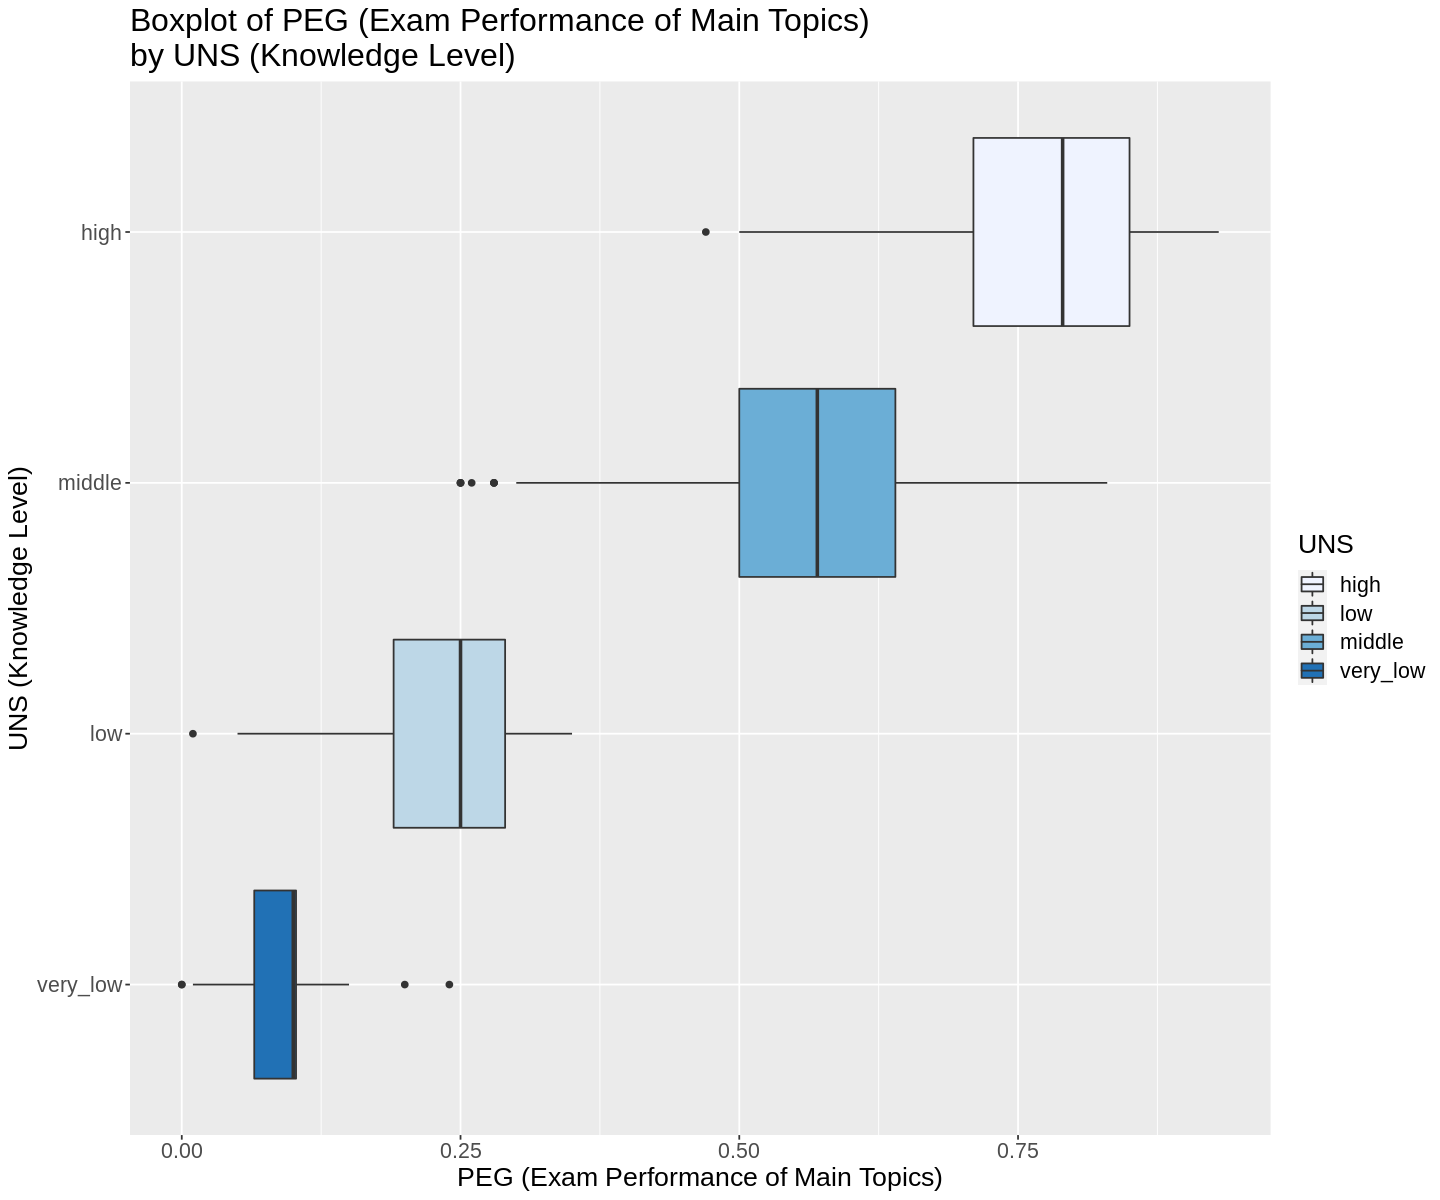

In [54]:
user_knowledge_plot <- ggplot(user_knowledge, aes(x = PEG, y = reorder(UNS, +PEG, median), fill = UNS)) +
    geom_boxplot() +
    labs(x = "PEG (Exam Performance of Main Topics)", y = "UNS (Knowledge Level)") +
    ggtitle("Boxplot of PEG (Exam Performance of Main Topics) \nby UNS (Knowledge Level)") + 
    scale_fill_brewer(palette="Blues") +
    theme(text = element_text(size = 16)) 

user_knowledge_plot

*Figure 1*: Boxplot of `PEG` by `UNS`

Looking at *Figure 1*, we can see that `very_low` has the lowest `PEG` median while `high` has the highest `PEG` median. We can conclude that as `PEG` increases, so does the `UNS` as seen with the medians of each boxplot. This indicates that there is a positive relationship between `PEG` and the different levels of `UNS` based on the medians. The relationship is also strong as the medians differ greatly across the different levels. Hence, `PEG` does affect the levels of `UNS`, and impacts them greatly. This will be discussed in our data analysis section.

We can make similar boxplots showing the relationship between `LPR` and each level of `UNS`.

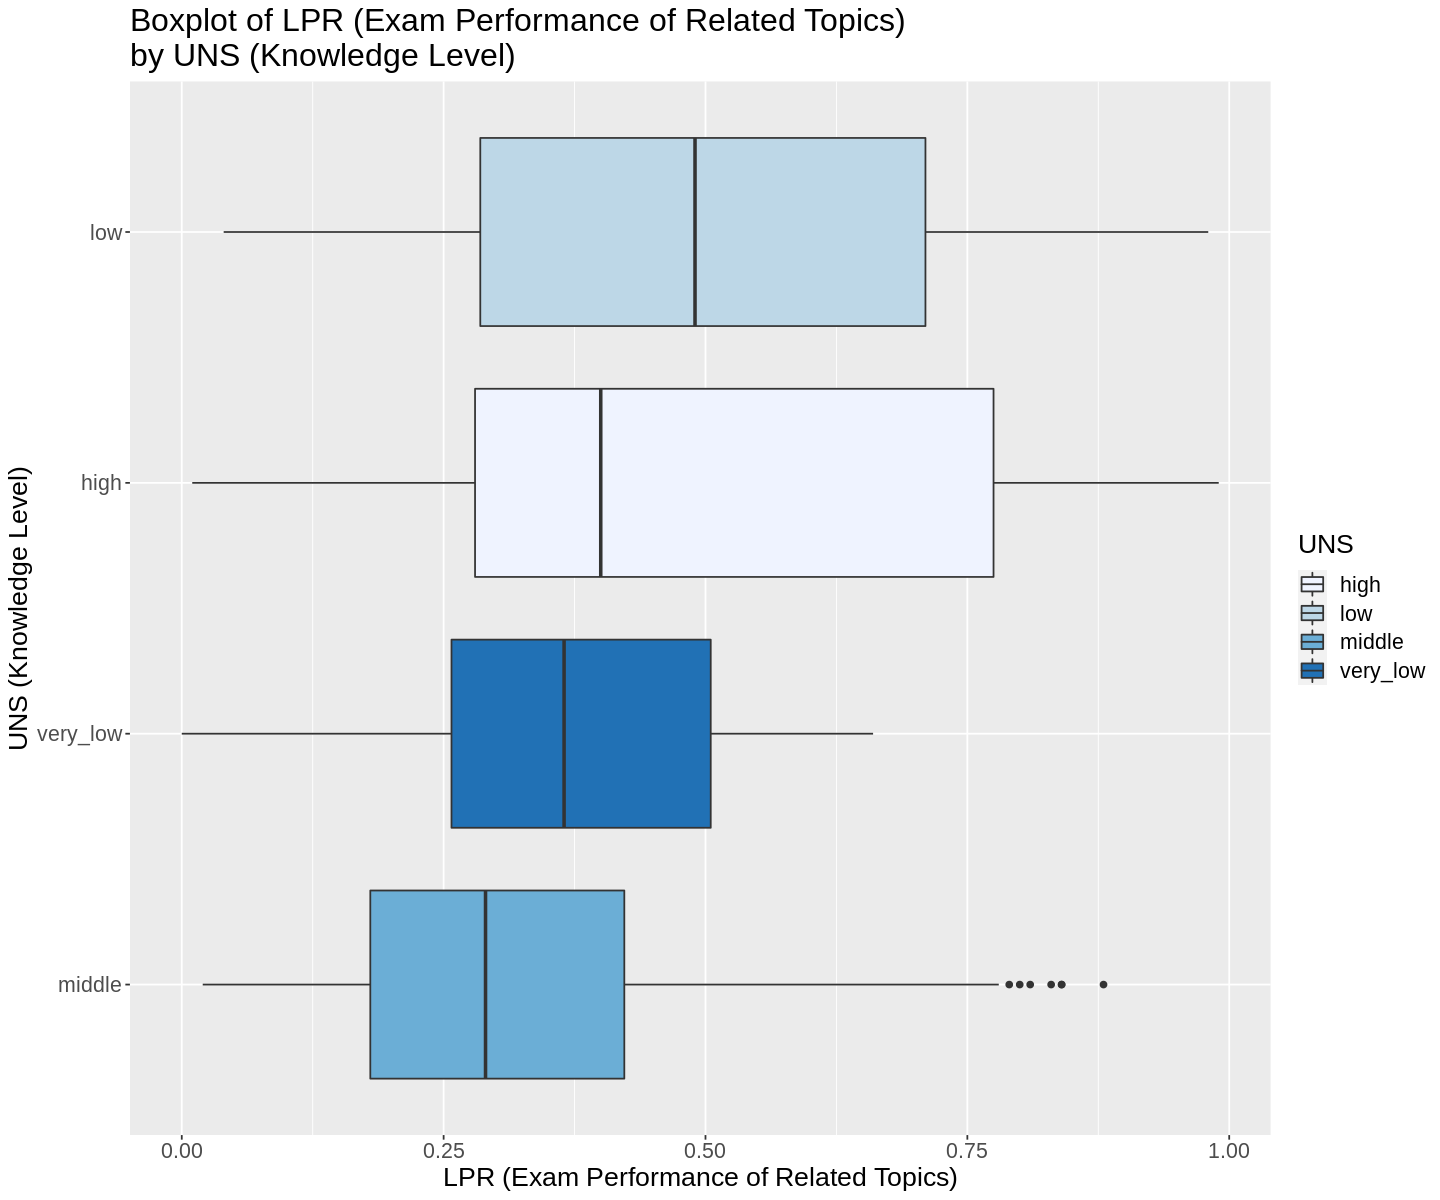

In [51]:
user_knowledge_plot_2 <- ggplot(user_knowledge, aes(x = LPR, y = reorder(UNS, +LPR, median), fill = UNS)) +
    geom_boxplot() +
    labs(x = "LPR (Exam Performance of Related Topics)", y = "UNS (Knowledge Level)") +
    ggtitle("Boxplot of LPR (Exam Performance of Related Topics) \nby UNS (Knowledge Level)") + 
    scale_fill_brewer(palette="Blues") +
    theme(text = element_text(size = 16)) 

user_knowledge_plot_2

*Figure 2*: Boxplot of `LPR` by `UNS`

Looking at *Figure 2*, we can see that `middle` has the lowest `LPR`, `very low` has the second lowest, `high` has the second highest, and `low` has the highest. We can see that there is no clear relationship between `LPR` and the different levels of `UNS`. Although, it is hard to come to this conclusion solely looking at the medians. For now, we will consider that there is no relationship but we will further investigate this relationship in the data analysis section

## Summarizing the Data Set

Now, we will summarize the data set to obtain statistics which will be used for the data analysis section.  

First, we start by calculating the mean, median, and standard deviation of both `PEG` and `LPR` in the data set.

In [57]:
peg_stats <- user_knowledge %>%
    summarize(mean_peg = mean(PEG),
              med_peg = median(PEG), 
              sd_peg = sd(PEG))

peg_stats

mean_peg,med_peg,sd_peg
<dbl>,<dbl>,<dbl>
0.4585388,0.5,0.2552109


*Table 5*: Mean, median, and standard deviation of `PEG`

Here, the `PEG` mean is around 0.46. The `PEG` median is 0.5, and the standard deviation is around 0.26.

In [58]:
lpr_stats <- user_knowledge %>%
    summarize(mean_lpr = mean(LPR),
              med_lpr = median(LPR), 
              sd_lpr = sd(LPR))

lpr_stats

mean_lpr,med_lpr,sd_lpr
<dbl>,<dbl>,<dbl>
0.4327132,0.33,0.248108


*Table 6*: Mean, median, and standard deviation of `LPR`

On the other hand, the `LPR` mean is around 0.43. The `LPR` median is 0.33, and the standard deviation is around 0.25.

Next, we found the number and percentage of the levels of `UNS` in our data set with the `group_by` and `summarize` functions. This will let us see if one label is more frequent compared to others.

In [59]:
UNS_proportions <- user_knowledge %>%
    group_by(UNS) %>%
    summarize(n = n()) %>%
    mutate(percent = 100 * n / nrow(user_knowledge))

UNS_proportions

`summarise()` ungrouping output (override with `.groups` argument)



UNS,n,percent
<fct>,<int>,<dbl>
high,63,24.418605
low,83,32.170543
middle,88,34.108527
very_low,24,9.302326


*Table 7*: Proportions of each UNS level 

For our training data, we have 63 (24%) highs, 88 (34%) middles, 83 (32%) lows and 24 (9%) very lows in our data set regarding levels of `UNS`. We can see that there are more `middle` and `low` labels compared to `high` labels, and much more compared to `very low` labels.

We can also find the range of `PEG` and `LPR` in our data set.

In [60]:
peg_range <- range(user_knowledge$PEG)

peg_range

[1] 0.00 0.93

The lowest `PEG` value observed is 0 and the largest observed is 0.93.

In [61]:
lpr_range <- range(user_knowledge$LPR)

lpr_range

[1] 0.00 0.99

The lowest `LPR` value observed is 0 while the largest observed is 0.99.

## Building the Classifier

Firstly, we need to create a recipe to preprocess our unscaled data. By doing so, our predictors will be scaled and centered.

In [62]:
user_knowledge_recipe <- recipe(UNS ~ PEG + LPR, data = user_knowledge) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

user_knowledge_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Now, we will try to find the optimal value of K to use in our classifier by performing a 10-fold cross-validation on our training data. We use the `vfold_cv` function along with the data set, the number of folds (v), and the strata arguments. The strata argument contains our categorical variable `UNS`.  

In [63]:
user_knowledge_vfold <- vfold_cv(user_knowledge, v = 10, strata = UNS)
print(user_knowledge_vfold)

#  10-fold cross-validation using stratification 
# A tibble: 10 x 2
   splits           id    
   <list>           <chr> 
 1 <split [231/27]> Fold01
 2 <split [231/27]> Fold02
 3 <split [231/27]> Fold03
 4 <split [231/27]> Fold04
 5 <split [231/27]> Fold05
 6 <split [232/26]> Fold06
 7 <split [233/25]> Fold07
 8 <split [234/24]> Fold08
 9 <split [234/24]> Fold09
10 <split [234/24]> Fold10


Now, we will build our tune model. Since we want to do a classification, we will specify the engineer as `kknn` and the mode as `classification`. We will also use `tune()` in the neighbors argument since we have not yet chosen a K value. 

In [64]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Next, we will perform cross-validation across the folds with our prepared recipe and tune model. We will make a data frame called `k_vals` that contains K values from 1 to 100, incrementing by 5. `k_vals` will be used in the `tune_grid` function. Then, `collect_metrics` is used to collect the cross-validation results. Finally, we will filter `.metric` by accuracy to obtain the accuracy for each potential K value.

In [65]:
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

user_knowledge_results <- workflow() %>%
    add_recipe(user_knowledge_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = user_knowledge_vfold, grid = k_vals) %>%
    collect_metrics()%>% 
    filter(.metric == "accuracy") 

user_knowledge_results

! Fold05: internal: No observations were detected in `truth` for level(s): 'very_l...



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9426410,10,0.008305606,Model01
6,accuracy,multiclass,0.9488148,10,0.018812243,Model02
11,accuracy,multiclass,0.9449444,10,0.016951792,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
86,accuracy,multiclass,0.6187735,10,0.02489364,Model18
91,accuracy,multiclass,0.6071994,10,0.02287582,Model19
96,accuracy,multiclass,0.5908533,10,0.02805795,Model20


*Table 8*: Results from 10-fold cross validation

With the table above, we can create a plot using the number of neighbors on the x-axis and the accuracy estimate on the y-axis to choose the best K value for our classifier.

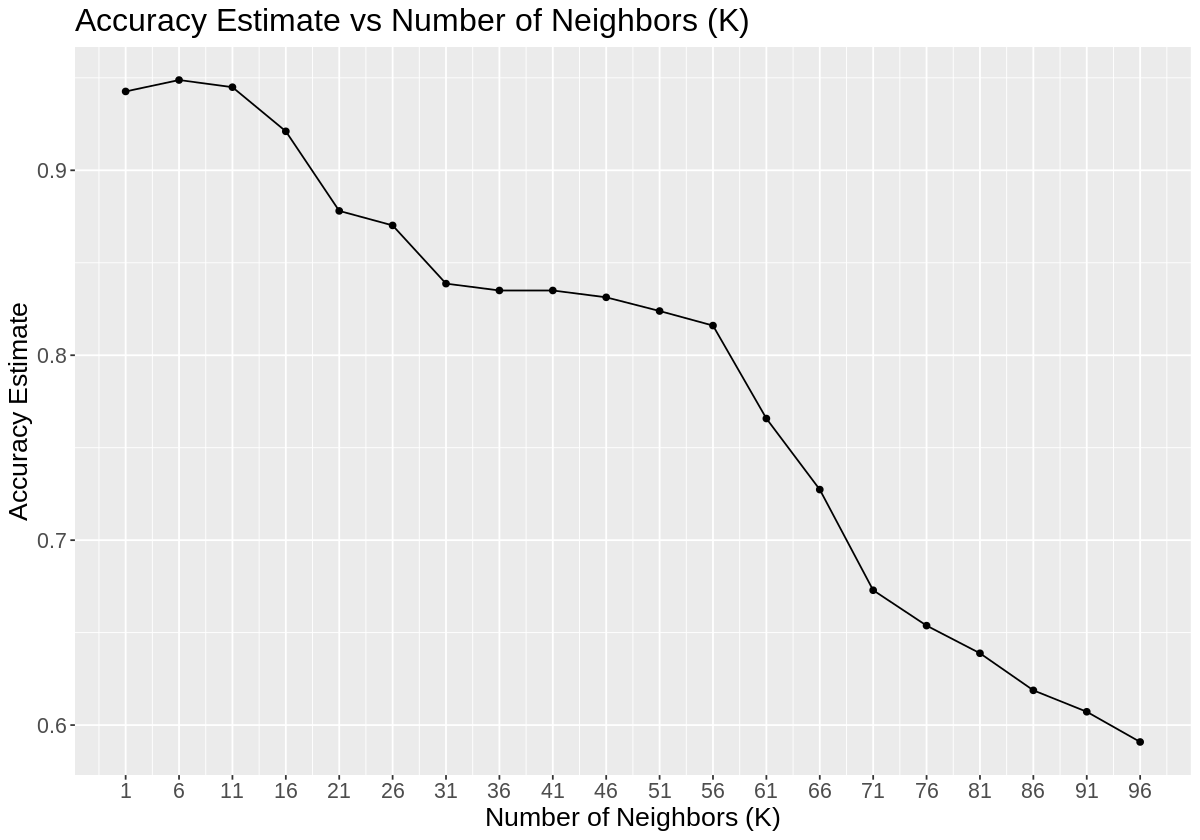

In [66]:
options(repr.plot.width = 10, repr.plot.height = 7)

accuracy_versus_k <- ggplot(user_knowledge_results, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Neighbors (K)", y = "Accuracy Estimate") +
    ggtitle("Accuracy Estimate vs Number of Neighbors (K)") +
    theme(text = element_text(size = 16)) +
    scale_x_continuous(breaks = seq(1, 96, by = 5))

accuracy_versus_k

*Figure 3*: Plot of accuracy estimate vs number of neighbors

We take the K with the highest accuracy estimate to use in the classifier. In this case, any value between 1 to 11 would be acceptable as they have the highest accuracy estimate. Looking at the graph, we can see that it peaks at K = 6, and the range from K = 6 to K = 11 displays the highest accuracy. Thus, we have decided to use K = 7 as our K value should be an odd number to avoid ties. It has one of the highest accuracy estimate relative to other points and it is a low K value. We will remake our model using K = 7.

In [67]:
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) %>%
          set_engine("kknn") %>%
          set_mode("classification")

knn_spec_2

user_knowledge_fit <- workflow() %>%
                      add_recipe(user_knowledge_recipe) %>%
                      add_model(knn_spec_2) %>%
                      fit(data = user_knowledge)

user_knowledge_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 7
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~7, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.04263566
Best kernel: rectangular
Best k: 7

To evaluate the estimated accuracy of our classifier on the test set, we use the `predict` and `bind_cols` functions. We can compare the .pred_class column (which contains the predictions from our classifier) with the `UNS` column (which contains the true values).

In [88]:
user_knowledge_train <- read_excel(path = "Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls", sheet = 3) %>%
    select(LPR, PEG, UNS) %>%
    mutate(UNS = gsub(" ", "", UNS)) %>%
    mutate(UNS = recode(UNS, High = "high", Middle = "middle", Low = "low", VeryLow = "very_low")) %>%
    mutate(UNS = as.factor(UNS))

user_knowledge_test_predictions <- predict(user_knowledge_fit, user_knowledge_train) %>%
                                   bind_cols(user_knowledge_train)

user_knowledge_test_predictions

New names:
* `` -> ...7
* `` -> ...8



.pred_class,LPR,PEG,UNS
<fct>,<dbl>,<dbl>,<fct>
very_low,0.26,0.05,very_low
low,0.60,0.14,low
high,0.60,0.85,high
⋮,⋮,⋮,⋮
low,0.13,0.32,low
middle,0.57,0.57,middle
middle,0.97,0.24,middle


*Table 9*: Testing data with our classifier's predictions added

To get statistics about the quality of our model, we will use the `metrics` function and filter `.metrics` by accuracy to see the accuracy estimate.

In [89]:
user_knowledge_prediction_accuracy <- user_knowledge_test_predictions %>%
                metrics(truth = UNS, estimate = .pred_class) %>%
                filter(.metric == "accuracy")

user_knowledge_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9586207


*Table 10*: The metrics of classifier's predictions on the testing data

The estimated accuracy of our classifier on the testing data is around 96% accurate. We will look at the confusion matrix to see the correct and incorrect predictions made by our classifier.

In [90]:
user_knowledge_mat <- user_knowledge_test_predictions %>% 
      conf_mat(truth = UNS, estimate = .pred_class)

user_knowledge_mat

          Truth
Prediction high low middle very_low
  high       39   0      1        0
  low         0  45      2        2
  middle      0   1     31        0
  very_low    0   0      0       24

*Table 11*: Confusion matrix showing correct and incorrect predictions

Our classifier predicted `high` correctly 39 times and incorrectly 0 times. It predicted `middle` correctly 31 times and incorrectly 3 times. It predicted `low` correctly 45 times and incorrectly 1 times. It also predicted `very_low` correctly 24 time and incorrectly 2 times. 

To test some made-up observations, we will create some tibbles and predict their `UNS` with our classifier. The first tibble we have created represents an average student, using the mean STG and STR value we calculated in the "Summarizing the Data Set" section.

In [91]:
first_observation <- tibble(PEG = 0.46, LPR = 0.43)

first_prediction <- predict(user_knowledge_fit, first_observation)

first_prediction

.pred_class
<fct>
middle


The classifier predicted that this observation would be labelled as `middle`. This is rather accurate as we would expect an average student would be predicted as either a `low` or `middle` level, which would be considered as an average level. 

We will do another test observation of a student in the 90th percentile. We will use 90% of the largest STG and STR that we found in the "Summarizing the Data Set" section. 

In [92]:
second_observation <- tibble(PEG = 0.9 * 0.93, LPR = 0.9 * 0.99)

second_prediction <- predict(user_knowledge_fit, second_observation)

second_prediction

.pred_class
<fct>
high


The classifier predicted that this observation would also be labelled as `high`. In this case, `high` is an appropriate prediction as a student in the 90th percentile probably has a higher knowledge level.

Now, we will be visualizing our data by creating a graph, which has `LPR` on the x-axis, `PEG` on the y-axis, and colours each point based on `UNS`. Then, we will also add our hypothetical data points on the graph.

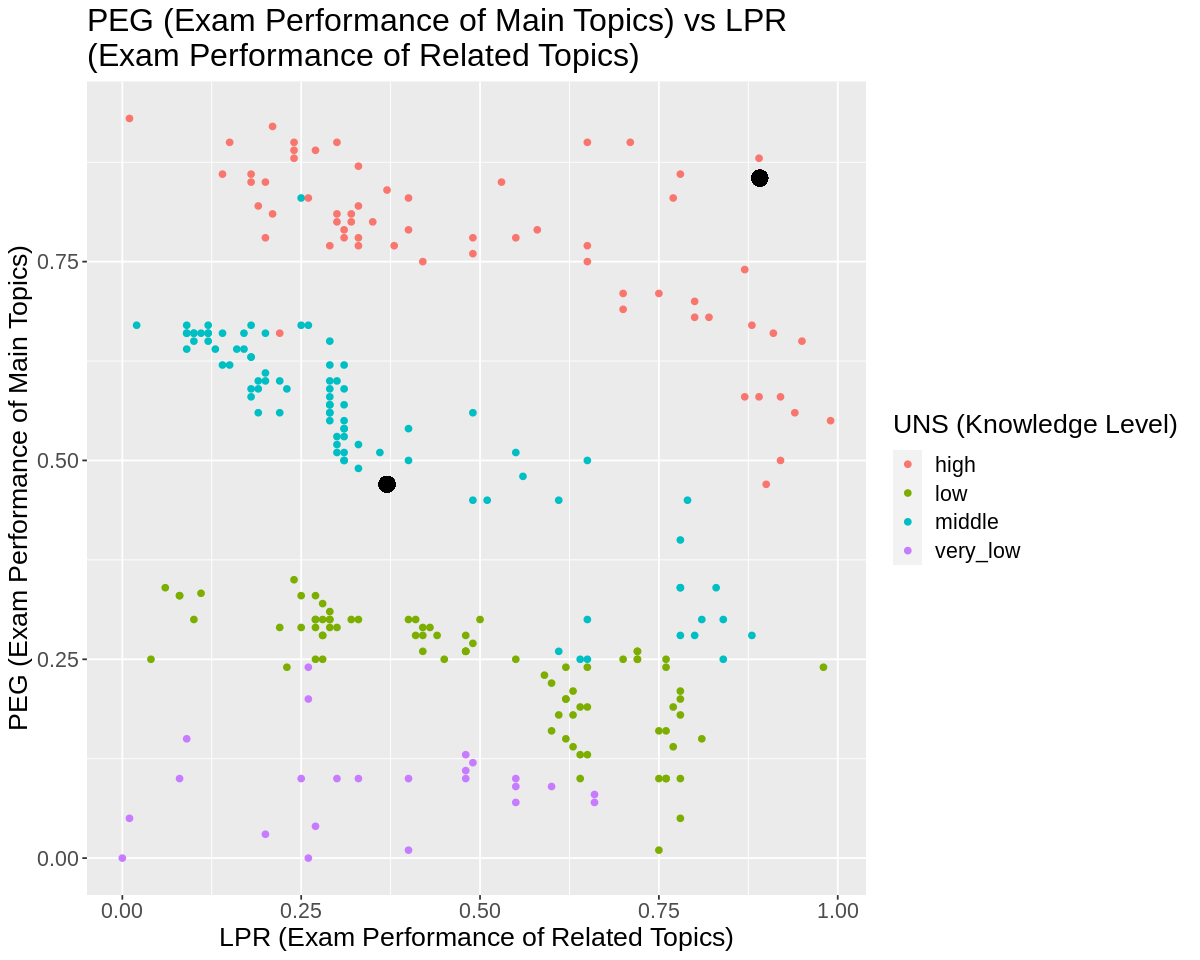

In [93]:
options(repr.plot.width = 10, repr.plot.height = 8)

user_knowledge_graph <- user_knowledge %>%
    ggplot(aes(x = LPR, y = PEG, color = UNS)) + 
    geom_point() + 
    labs(x = "LPR (Exam Performance of Related Topics)", y = "PEG (Exam Performance of Main Topics)", color = "UNS (Knowledge Level)") +
    ggtitle("PEG (Exam Performance of Main Topics) vs LPR \n(Exam Performance of Related Topics)") + 
    theme(text = element_text(size = 16)) +
    geom_point(aes(x = 0.37, y = 0.47), color = "black", size = 4) + 
    geom_point(aes(x = 0.9 * 0.99, y = 0.9 * 0.95), color = "black", size = 4) 
    

user_knowledge_graph

*Figure 4*: Plot of `PEG` vs `LPR` colored by `UNS` with the additional two created observations

We can see that the point representing an average student is relatively close to an observations with `UNS` level of `middle`. It seems like a clear consensus that the average student also be labelled as `middle` based on these known observations. Similarly, regarding the point representing a student in the 90th percentile, it is mainly close to points with the `UNS` of `high`. Again, it is a clear consensus that this student will be labelled as `high`. We will discuss more about this in the following section.

## Data Analysis and Discussion

Next, we can create another graph visualizing our predictions to see if there are any interesting patterns.

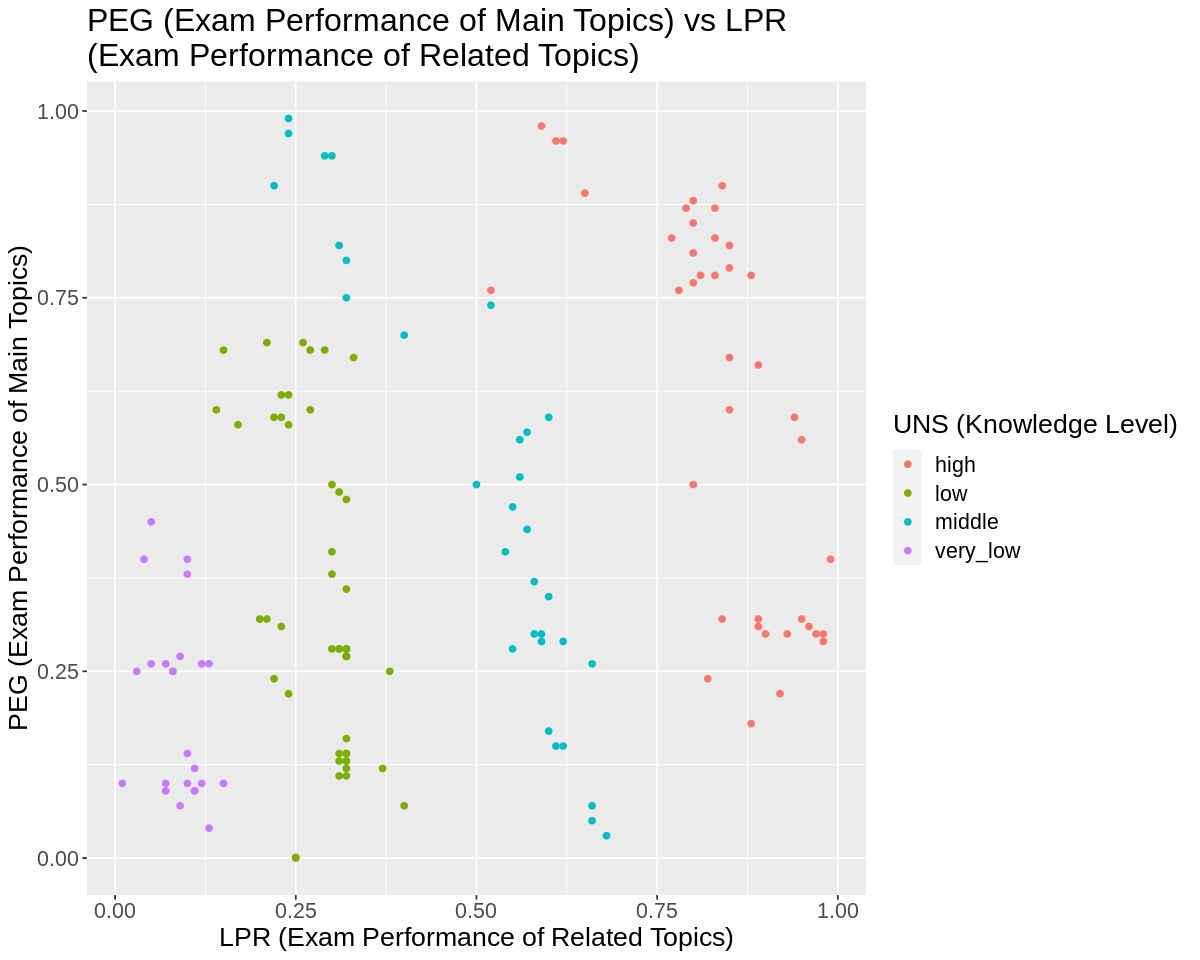

In [94]:
options(repr.plot.width = 10, repr.plot.height = 8)

predictions_graph <- user_knowledge_test_predictions %>%
    ggplot(aes(x = PEG, y = LPR, color = .pred_class)) +
    geom_point() +
    labs(x = "LPR (Exam Performance of Related Topics)", y = "PEG (Exam Performance of Main Topics)", color = "UNS (Knowledge Level)") +
    ggtitle("PEG (Exam Performance of Main Topics) vs LPR \n(Exam Performance of Related Topics)") +
    theme(text = element_text(size = 16)) 

predictions_graph

*Figure 5*: Plot of `PEG` vs `LPR` coloured by `UNS` based on predicting the training data

To help with our discussion, we will make a plot similar to the `user_knowledge_graph`. However, this graph will colour the background based on the decision of our classifier. 

*Note: The following code was taken from Chapter 5.8 of the textbook.*

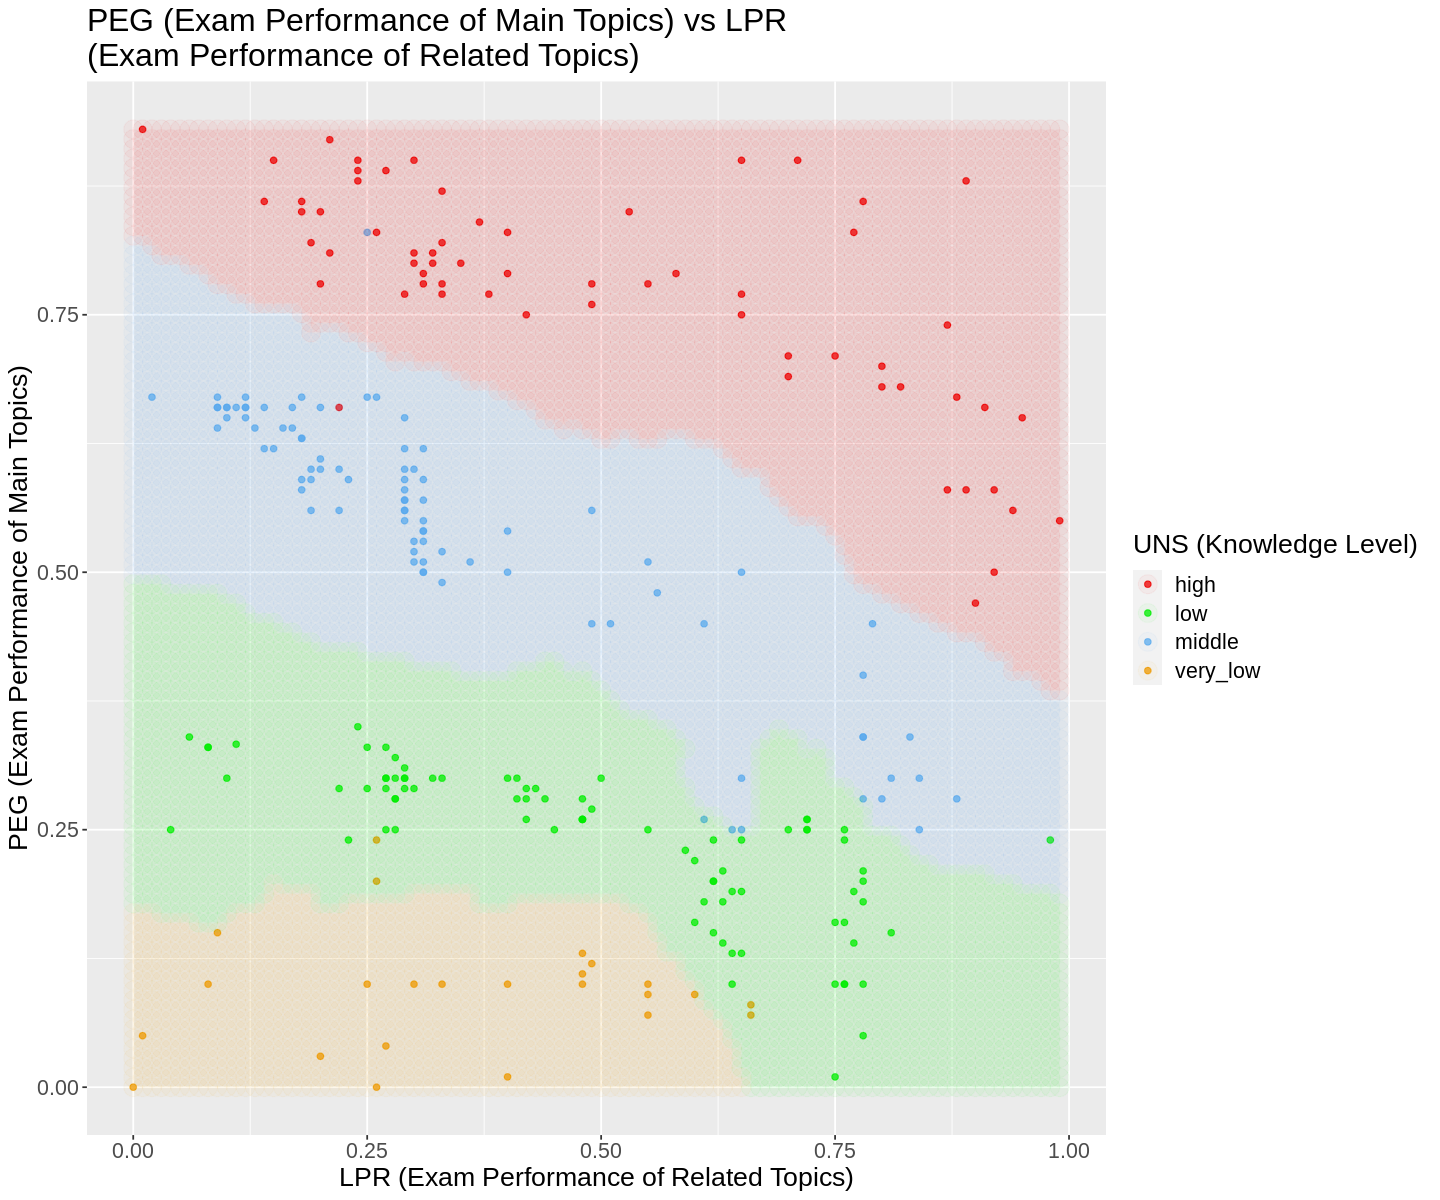

In [95]:
options(repr.plot.width = 12, repr.plot.height = 10)

are_grid <- seq(min(user_knowledge$LPR), 
                max(user_knowledge$LPR), 
                length.out = 100)

smo_grid <- seq(min(user_knowledge$PEG), 
                max(user_knowledge$PEG), 
                length.out = 100)

asgrid <- as_tibble(expand.grid(LPR = are_grid, 
                                PEG = smo_grid))

knnPredGrid <- predict(user_knowledge_fit, asgrid)

prediction_table <- bind_cols(knnPredGrid, asgrid) %>% 
  rename(UNS = .pred_class)

user_knowledge_graph_2 <- ggplot() +
    geom_point(data = user_knowledge, 
               mapping = aes(x = LPR, 
                             y = PEG, 
                             color = UNS), 
               alpha = 0.75) +
    geom_point(data = prediction_table, 
               mapping = aes(x = LPR, 
                             y = PEG, 
                             color = UNS), 
               alpha = 0.04, 
               size = 5) +
    labs(x = "LPR (Exam Performance of Related Topics)", y = "PEG (Exam Performance of Main Topics)", color = "UNS (Knowledge Level)") +
    ggtitle("PEG (Exam Performance of Main Topics) vs LPR \n(Exam Performance of Related Topics)") +
    scale_color_manual(labels = c("high", "low", "middle", "very_low"), 
                       values = c("red2", "green2", "steelblue2", "orange2")) +
    theme(text = element_text(size = 16))

user_knowledge_graph_2

*Figure 6*: Plot of `PEG` vs `LPR` where background colour represents the decision of our classifier

### Discussion

Ultimately, let's go back to our predictive question “Can we predict the `UNS` of an individual based on factors such as `STG`, `SCG`, and `STR`?”.
The user_knowledge classifier shows a very low accuracy of 37.9% which points out the very weak correlations of the `UNS` and the two predictors (`STG` & `STR`). Due to the very low accuracy, we are not able to accurately predict the knowledge level of users based on the degree of study time for goal object materials, the degree of repetition number of users for goal object materials, and the degree of study time of the user for related objects with goal object.

However, this is not what we expected before since textually, both of `STG` and `STR` are very relevant to the `UNS`. The imbalanced data might be the reason why the classifier has a very low accuracy. 

In [32]:
UNS_proportions

UNS,n,percent
<fct>,<int>,<dbl>
high,63,24.418605
low,83,32.170543
middle,88,34.108527
very_low,24,9.302326


#### Effect of the Imbalanced Data

From the summarizing of the data set part, we have known there are 63 (24%) highs, 88 (34%) middles, 83 (32%) lows, and 24 (9%) very lows in our training data set regarding levels of UNS. We can see that there are fewer very low labels and high labels compared to low labels, and much fewer compared to middle labels. 

In [34]:
user_knowledge_mat

          Truth
Prediction high low middle very_low
  high       10   4      7        3
  low        10  26      9       15
  middle     19  16     18        7
  very_low    0   0      0        1

Since we are using the K-nearest neighbors classification method to let 7 nearest points vote for the label and training the model by the imbalanced data, the middles' label and lows' label are much more common than another (more voting chance), we have higher predicted accuracy for the `middles` (52.9%) and `lows` (56.5%) than the other two classes. When we set the background color of each area of our to scatter plot to the decision the K-nearest neighbor classifier would make, we can see that the `middles` and `lows` have the largest region (voting chances) from the `user_knowledge_graph_2`(figure 6).

#### Further questions

There is some further predictive questions that we may do based on the data of user_knowledge:

Can we predict the `UNS` (the knowledge level of the user) based on the `LPR` (the exam performance of the user for related objects with the goal object)? To address this problem we will use the K-nearest neighbors classification.

Can we predict the `PEG` (the exam performance of user for goal objects) based on factors such as the LPR (the exam performance of user for related objects with goal object), `STG`, `SCG`, and `STR`? To address this problem we will use the regression method since PEG is a quantative variable.